<a href="https://colab.research.google.com/github/componavt/sns4human/blob/main/src/vk/nlp/scikit_LDA_topics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
# topics are indicated by an expert for each social network post
filename = '512_posts_24_topics.csv'

# the number of topics the Latent Dirichlet Allocation (LDA) model must extract from the set of documents
n_components = 24



In [56]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
!pip install -U pymorphy3
import pymorphy3
import requests
import csv
import gzip
import shutil

nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

from nltk.corpus import stopwords
stop_words = stopwords.words("russian")

#stop_words += requests.get('https://raw.githubusercontent.com/componavt/sns4human/refs/heads/main/src/vk/nlp/RussianStopWords.txt').text.split('\n')
#stop_words += requests.get('https://raw.githubusercontent.com/componavt/sns4human/refs/heads/main/src/vk/nlp/stopwords-ru.txt').text.split()
alphabet = set('абвгдеёжзийклмнопрстуфхцчшщъыьэюя')
alphabet_dash = alphabet | {'-'}# alphabet + dash

morph = pymorphy3.MorphAnalyzer(lang='ru')

from io import StringIO
response = requests.get(f'https://raw.githubusercontent.com/componavt/sns4human/refs/heads/main/data/vk/topics/{filename}')
df = pd.read_csv(StringIO(response.text), delimiter=',', encoding='utf-8')
print(df.index.name)

None


In [57]:
def get_text_window(words, index, window_size=3):
    """Returns a context window of words around the given index."""
    start = max(0, index - window_size)
    end = min(len(words), index + window_size + 1)
    return ' '.join(words[start:end])

def contains_non_dash(s):
    """Check if a string consists not only dash characters."""
    return s.count('-') < len(s)

def process_text(text):
    sentences = sent_tokenize(text)  # Split into sentences
    processed_sentences = []

    for sentence in sentences:
        check_hash = False
        processed_parts = []
        words = word_tokenize(sentence)

        for i, w in enumerate(words):
          if len(w) == 1:
            continue
          if w == '#':
            check_hash = True
            continue
          if check_hash:
            check_hash = False
            continue

          # skip name and surname
          # w_tag = morph.parse(w.strip())[0].tag
          #if 'Surn' in w_tag or 'Name' in w_tag or 'Patr' in w_tag:
          #  context = get_text_window(words, i)
          #  print(f"Filtered name/surname: {w} | Context: {context}")  # Debug output for context
          #  continue

          if set(w.lower()).issubset(alphabet_dash) and contains_non_dash(w):
            res = morph.parse(w.lower())[0].normal_form
            if res and (res not in stop_words):
                  processed_parts.append(res)
          else:
            # has 4+ Cyrillic characters then will parse too (e.g. блж.Фаддея о.Алексия г.Петрозаводске)
            if sum(1 for char in w.lower() if char in alphabet) >= 4:
              if ('\\' not in w) and ('/' not in w): # skip words-hyperlinks
                #context = get_text_window(words, i)
                #print(f"Filtered not subset(alphabet): {w} | Context: {context}")
                res = morph.parse(w.lower())[0].normal_form
                if res not in stop_words:
                  processed_parts.append(res)

        if processed_parts:
            last_word = processed_parts[-1]
            if last_word[-1] not in ".!?":
                #processed_parts.append(".")  # Add period at the end of sentence
                processed_parts[-1] += "."    # Attach period directly to the last word

        processed_sentences.append(" ".join(processed_parts))

    return " ".join(processed_sentences).strip()

In [58]:
!pip install pymorphy3
import pymorphy3
morph = pymorphy3.MorphAnalyzer(lang='ru')

for index, row in df.iterrows():
    text = row['text'].lower()
    df.loc[index, 'normalized'] = process_text(row['text'])  # .lower())

In [59]:
from sklearn.model_selection import train_test_split
train_docs, test_docs = train_test_split(df, test_size=0.2, random_state=42, shuffle=True) # посчитать точность на тестовой сотне

unique_topics = sorted(train_docs['topic'].unique())  # sort topics by name
#print(f"Total topics: {len(unique_topics)}")
#for i, topic in enumerate(unique_topics, 1):  # print from 1
#    print(f"{i}. {topic}")

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create TF-IDF matrix
#vectorizer = TfidfVectorizer(max_df=.2, min_df=3, max_features=2000)
# TODO: CountVectorizer лучше?
vectorizer = CountVectorizer(
#vectorizer = TfidfVectorizer(
    max_df=0.8,        # Игнорировать слишком частые слова (в >80% документов)
    min_df=2,          # Игнорировать слова, встречающиеся только один раз
    max_features=1000, # Умеренное количество признаков
#    stop_words=stop_words,  # уже убрали
)

# Transform text into TF-IDF matrix
doc_train_matrix = vectorizer.fit_transform(train_docs['normalized'])
doc_test_matrix = vectorizer.transform(test_docs['normalized'])

# Get feature names
words = vectorizer.get_feature_names_out()

# Generate topic labels
topic_labels = ['Topic {}'.format(i) for i in range(1, n_components + 1)]

# Fit LDA model
lda = LatentDirichletAllocation(
    n_components=n_components,
    n_jobs=-1,
    max_iter=77,
    learning_method='batch',
    evaluate_every=10,
    verbose=1,
    random_state=42
)
lda.fit(doc_train_matrix)


# Save and load the model
joblib.dump(lda, 'model.pkl')
lda = joblib.load('model.pkl')

# Compute topic-word probabilities
topics_count = lda.components_
topics_prob = topics_count / topics_count.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T, index=words, columns=topic_labels)

# почему первый столбец - это названия группы в ВК (domain)?
topics.head()

iteration: 1 of max_iter: 77
iteration: 2 of max_iter: 77
iteration: 3 of max_iter: 77
iteration: 4 of max_iter: 77
iteration: 5 of max_iter: 77
iteration: 6 of max_iter: 77
iteration: 7 of max_iter: 77
iteration: 8 of max_iter: 77
iteration: 9 of max_iter: 77
iteration: 10 of max_iter: 77, perplexity: 60244.2570
iteration: 11 of max_iter: 77
iteration: 12 of max_iter: 77
iteration: 13 of max_iter: 77
iteration: 14 of max_iter: 77
iteration: 15 of max_iter: 77
iteration: 16 of max_iter: 77
iteration: 17 of max_iter: 77
iteration: 18 of max_iter: 77
iteration: 19 of max_iter: 77
iteration: 20 of max_iter: 77, perplexity: 46816.0845
iteration: 21 of max_iter: 77
iteration: 22 of max_iter: 77
iteration: 23 of max_iter: 77
iteration: 24 of max_iter: 77
iteration: 25 of max_iter: 77
iteration: 26 of max_iter: 77
iteration: 27 of max_iter: 77
iteration: 28 of max_iter: 77
iteration: 29 of max_iter: 77
iteration: 30 of max_iter: 77, perplexity: 44044.3664
iteration: 31 of max_iter: 77
iterati

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24
100,0.000529,0.000517,0.000413,0.000581,0.000210,0.000779,0.000072,0.000188,0.000532,0.000731,...,0.000576,0.000939,0.000134,0.000587,0.000715,0.010512,0.000698,0.000891,0.00071,0.000237
100словокарелия,0.000529,0.000517,0.000413,0.000581,0.023026,0.000779,0.000072,0.000188,0.000532,0.000731,...,0.000576,0.000939,0.000134,0.000587,0.000715,0.000513,0.000698,0.000891,0.00071,0.002548
club147415188,0.000529,0.000517,0.000413,0.000581,0.000210,0.000779,0.000072,0.004645,0.000532,0.000731,...,0.000576,0.000939,0.000134,0.000587,0.000715,0.000513,0.000698,0.000891,0.00071,0.000237
club791498,0.000529,0.000517,0.000413,0.000581,0.000210,0.000779,0.000072,0.000188,0.000532,0.000731,...,0.000576,0.000939,0.000134,0.000587,0.000715,0.000513,0.000698,0.000891,0.00071,0.000237
cамый,0.000529,0.000517,0.000413,0.000581,0.010526,0.000779,0.000072,0.000188,0.000532,0.000731,...,0.000576,0.000939,0.000134,0.000587,0.000715,0.000513,0.000698,0.000891,0.00071,0.000237


In [61]:
# Extract top words per topic
n_words = 12
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(n_words).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24
0,завтра,олонецкийнациональныймузей,карельский,водопад,пример,июль,карелия,конкурс,карел,зима,...,карелов,доска,карельский,сутки,питкяранта,ночь,загадка,вадим,изделие,слово
1,калевала,олонец,поговорка,постановка,слово,фестиваль,республика,национальный,ответ,кижи,...,научный,научиться,народный,человек,озеро,выпуск,соус,прислать,пудожский,финский
2,печь,калитка,молодёжь,клуб,язык,группа,год,организация,соревнование,совет,...,языковой,просмотр,песня,случай,октябрь,информационный,сезон,бизнес,любовь,название
3,печка,земля,сколько,собственно,свой,обсуждение,это,культура,старый,ремонт,...,институт,блюдо,культура,ситуация,гнездо,акции_нмрк,аварийный,рф,николаевич,сказка
4,дарья,гореть,сборник,карел,стена,отряд,весь,развитие,хоровой,дорога,...,сотрудник,готовить,хор,тест,ведлозеро,открытый,состояние,платформа,танец,всё
5,художник,калевала,море,юный,неделя,помочь,наш,заявка,речь,владимир,...,иванович,калитка,коллектив,съёмка,ещё,советский,пункт,малый,лето,карельский
6,записать,молоко,союз,улица,100словокарелия,присоединяться,день,министерство,приз,трасса,...,день,кухня,мероприятие,вспомнить,семёнович,казачий,человек,специальный,конкк,любимый
7,небольшой,тверской,пословица,тверской,опубликовать,мать,который,общественный,август,объект,...,литература,делать,руно,госпитализировать,самый,развитие,костомукша,учёт,добро,иметь
8,викторина,пусть,знать,артист,конец,делиться,район,государственный,активно,укрепление,...,калевала,приятный,карелия,пневмония,родный,сад,внимание,ролик,тяжёлый,воскресение
9,форма,организовать,эхо,сюжет,перевод,внимание,работа,область,пение,проходить,...,ран,видео,музыкальный,инфекция,светлый,начаться,населить,подробность,именно,ваш


In [62]:
# Predict topic distribution for training data
train_preds = lda.transform(doc_train_matrix)
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=train_docs.topic)

# Prepare topic assignment per document
df = train_eval.groupby(level='topic').idxmax(axis=1).reset_index(drop=True)
#topic_pred = train_eval.idxmax(axis=1) # Get the topic with the highest probability for each document
#df = topic_pred.groupby(train_eval.index).value_counts(normalize=True).unstack(fill_value=0) # Group by true topic and count predictions


<ipython-input-62-b115e5e76e15>:6: FutureWarning: DataFrameGroupBy.idxmax with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  df = train_eval.groupby(level='topic').idxmax(axis=1).reset_index(drop=True)


Text(0.5, 1.0, 'Training: Topic Distribution')

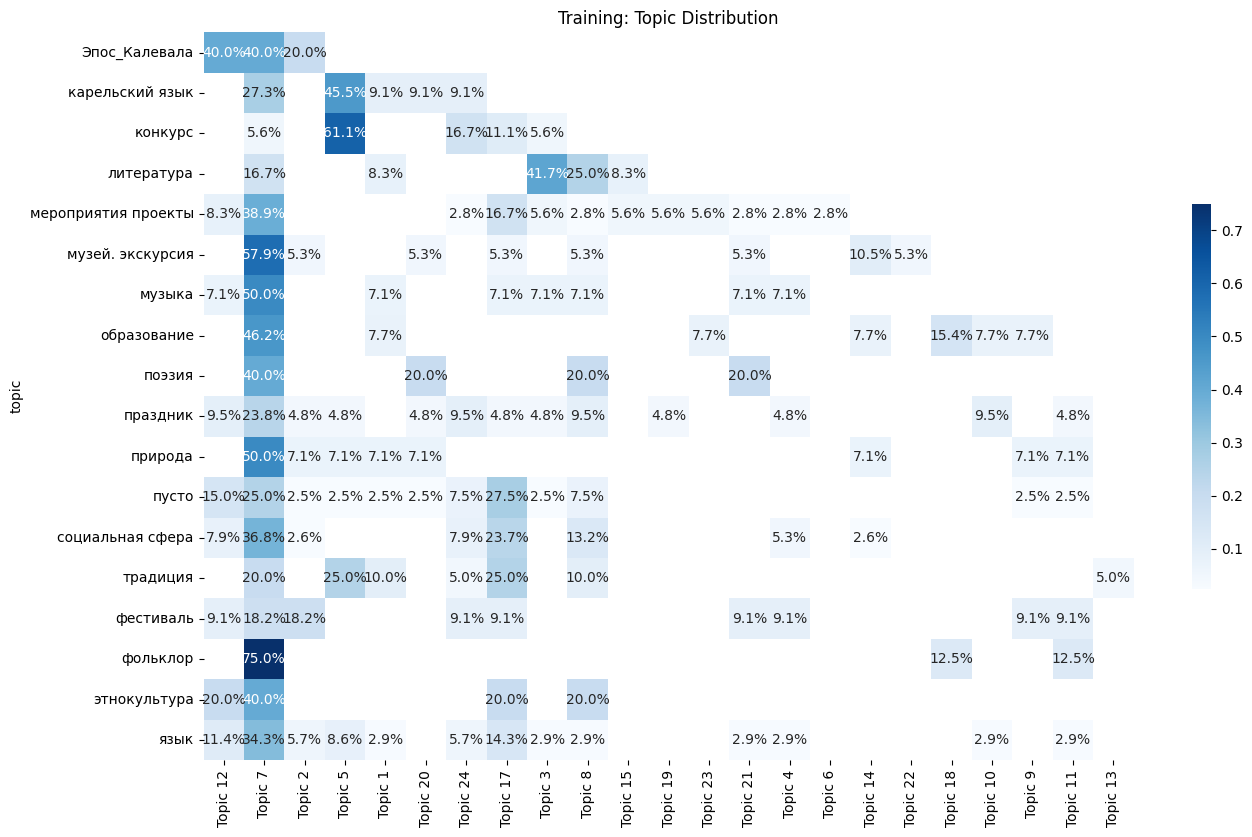

In [63]:
# Plot heatmap of topic distribution
plt.figure(figsize=(15, 10))
sns.heatmap(
    df.groupby(train_docs.topic).value_counts(normalize=True).unstack(-1),
    annot=True,
    fmt='.1%',
    cmap='Blues',
    square=True,
    cbar_kws={"shrink": 0.5}
)
plt.title('Training: Topic Distribution')
#plt.title('Обучение: Тематики')

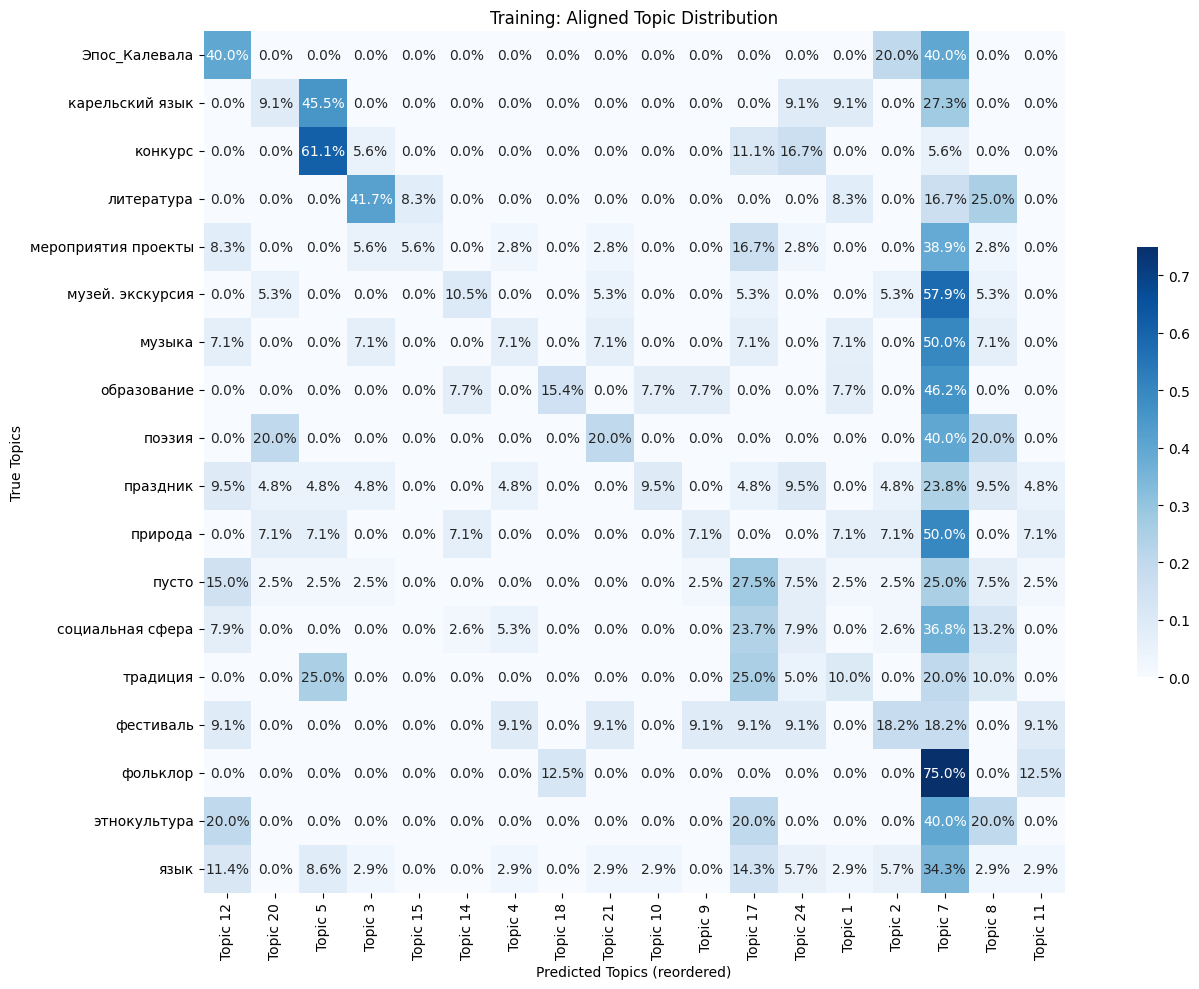

In [64]:
# Переупорядочиваем темы для максимального совпадения с истинными
confusion_matrix = df.groupby(train_docs.topic).value_counts(normalize=True).unstack(-1)

# Заполняем возможные NaN значения нулями и преобразуем к float
confusion_matrix = confusion_matrix.fillna(0).astype(float)

# Находим оптимальное сопоставление
from scipy.optimize import linear_sum_assignment
import numpy as np

try:
    row_ind, col_ind = linear_sum_assignment(-confusion_matrix.values)
    ordered_topics = confusion_matrix.columns[col_ind[np.argsort(row_ind)]]

    plt.figure(figsize=(15, 10))
    sns.heatmap(
        confusion_matrix.loc[confusion_matrix.index, ordered_topics],
        annot=True,
        fmt='.1%',
        cmap='Blues',
        square=True,
        cbar_kws={"shrink": 0.5}
    )
    plt.title('Training: Aligned Topic Distribution')
    plt.ylabel('True Topics')
    plt.xlabel('Predicted Topics (reordered)')
    plt.tight_layout()

except ValueError as e:
    print(f"Ошибка при обработке матрицы: {e}")
    print("Матрица для проверки:")
    print(confusion_matrix)
    print("Типы данных в матрице:")
    print(confusion_matrix.dtypes)

In [65]:
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=train_docs.topic)
train_eval

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24
topic,,,,,,,,,,,,,,,,,,,,,
мероприятия проекты,0.011158,0.011158,0.011158,0.011158,0.178431,0.267819,0.011158,0.011158,0.011158,0.011158,...,0.011158,0.011158,0.319435,0.011158,0.011158,0.011158,0.011158,0.011158,0.011158,0.011158
мероприятия проекты,0.005852,0.090600,0.005852,0.005852,0.005852,0.005852,0.350050,0.375595,0.005852,0.005852,...,0.005852,0.005852,0.005852,0.005852,0.005852,0.066724,0.005852,0.005852,0.005852,0.005852
пусто,0.006916,0.006916,0.006916,0.006916,0.006916,0.006916,0.251630,0.006916,0.006916,0.006916,...,0.006916,0.006916,0.204182,0.006916,0.006916,0.398958,0.006916,0.006916,0.006916,0.006916
образование,0.006400,0.006400,0.006400,0.006400,0.006400,0.006400,0.362680,0.093430,0.006400,0.006400,...,0.006400,0.006400,0.306588,0.006400,0.006400,0.086882,0.006400,0.006400,0.006400,0.006400
вепсы,0.010229,0.010229,0.010229,0.010229,0.010229,0.010229,0.764744,0.010229,0.010229,0.010229,...,0.010229,0.010229,0.010229,0.010229,0.010229,0.010229,0.010229,0.010229,0.010229,0.010229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
традиция,0.007330,0.007330,0.007330,0.007330,0.007330,0.007330,0.223811,0.007330,0.007330,0.007330,...,0.007330,0.007330,0.007330,0.007330,0.007330,0.007330,0.007330,0.007330,0.614939,0.007330
образование,0.005943,0.005943,0.005943,0.005943,0.005943,0.005943,0.281702,0.107679,0.005943,0.005943,...,0.078034,0.005943,0.169269,0.005943,0.046352,0.102607,0.005943,0.005943,0.005943,0.005943
мероприятия проекты,0.012194,0.012194,0.012194,0.012194,0.012194,0.012194,0.012194,0.012194,0.012194,0.012194,...,0.012194,0.012194,0.719527,0.012194,0.012194,0.012194,0.012194,0.012194,0.012194,0.012194


In [66]:
df = train_eval.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True)
train_eval = pd.DataFrame(data=lda.transform(doc_train_matrix),
                          columns=topic_labels,
                          index=train_docs.topic)
test_eval = pd.DataFrame(data=lda.transform(doc_test_matrix),
                         columns=topic_labels,
                         index=test_docs.topic)

<ipython-input-66-827e74a28c9f>:1: FutureWarning: DataFrameGroupBy.idxmax with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  df = train_eval.groupby(level='topic').idxmax(


**Визуализация в виде тепловой карты (heatmap) для анализа распределения тем в наборе данных: тестовый (test_eval)**

<ipython-input-67-9b315acb5e67>:1: FutureWarning: DataFrameGroupBy.idxmax with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  df = test_eval.groupby(level='topic').idxmax(


Text(0.5, 1.0, 'Данные обучения: Тематические задания')

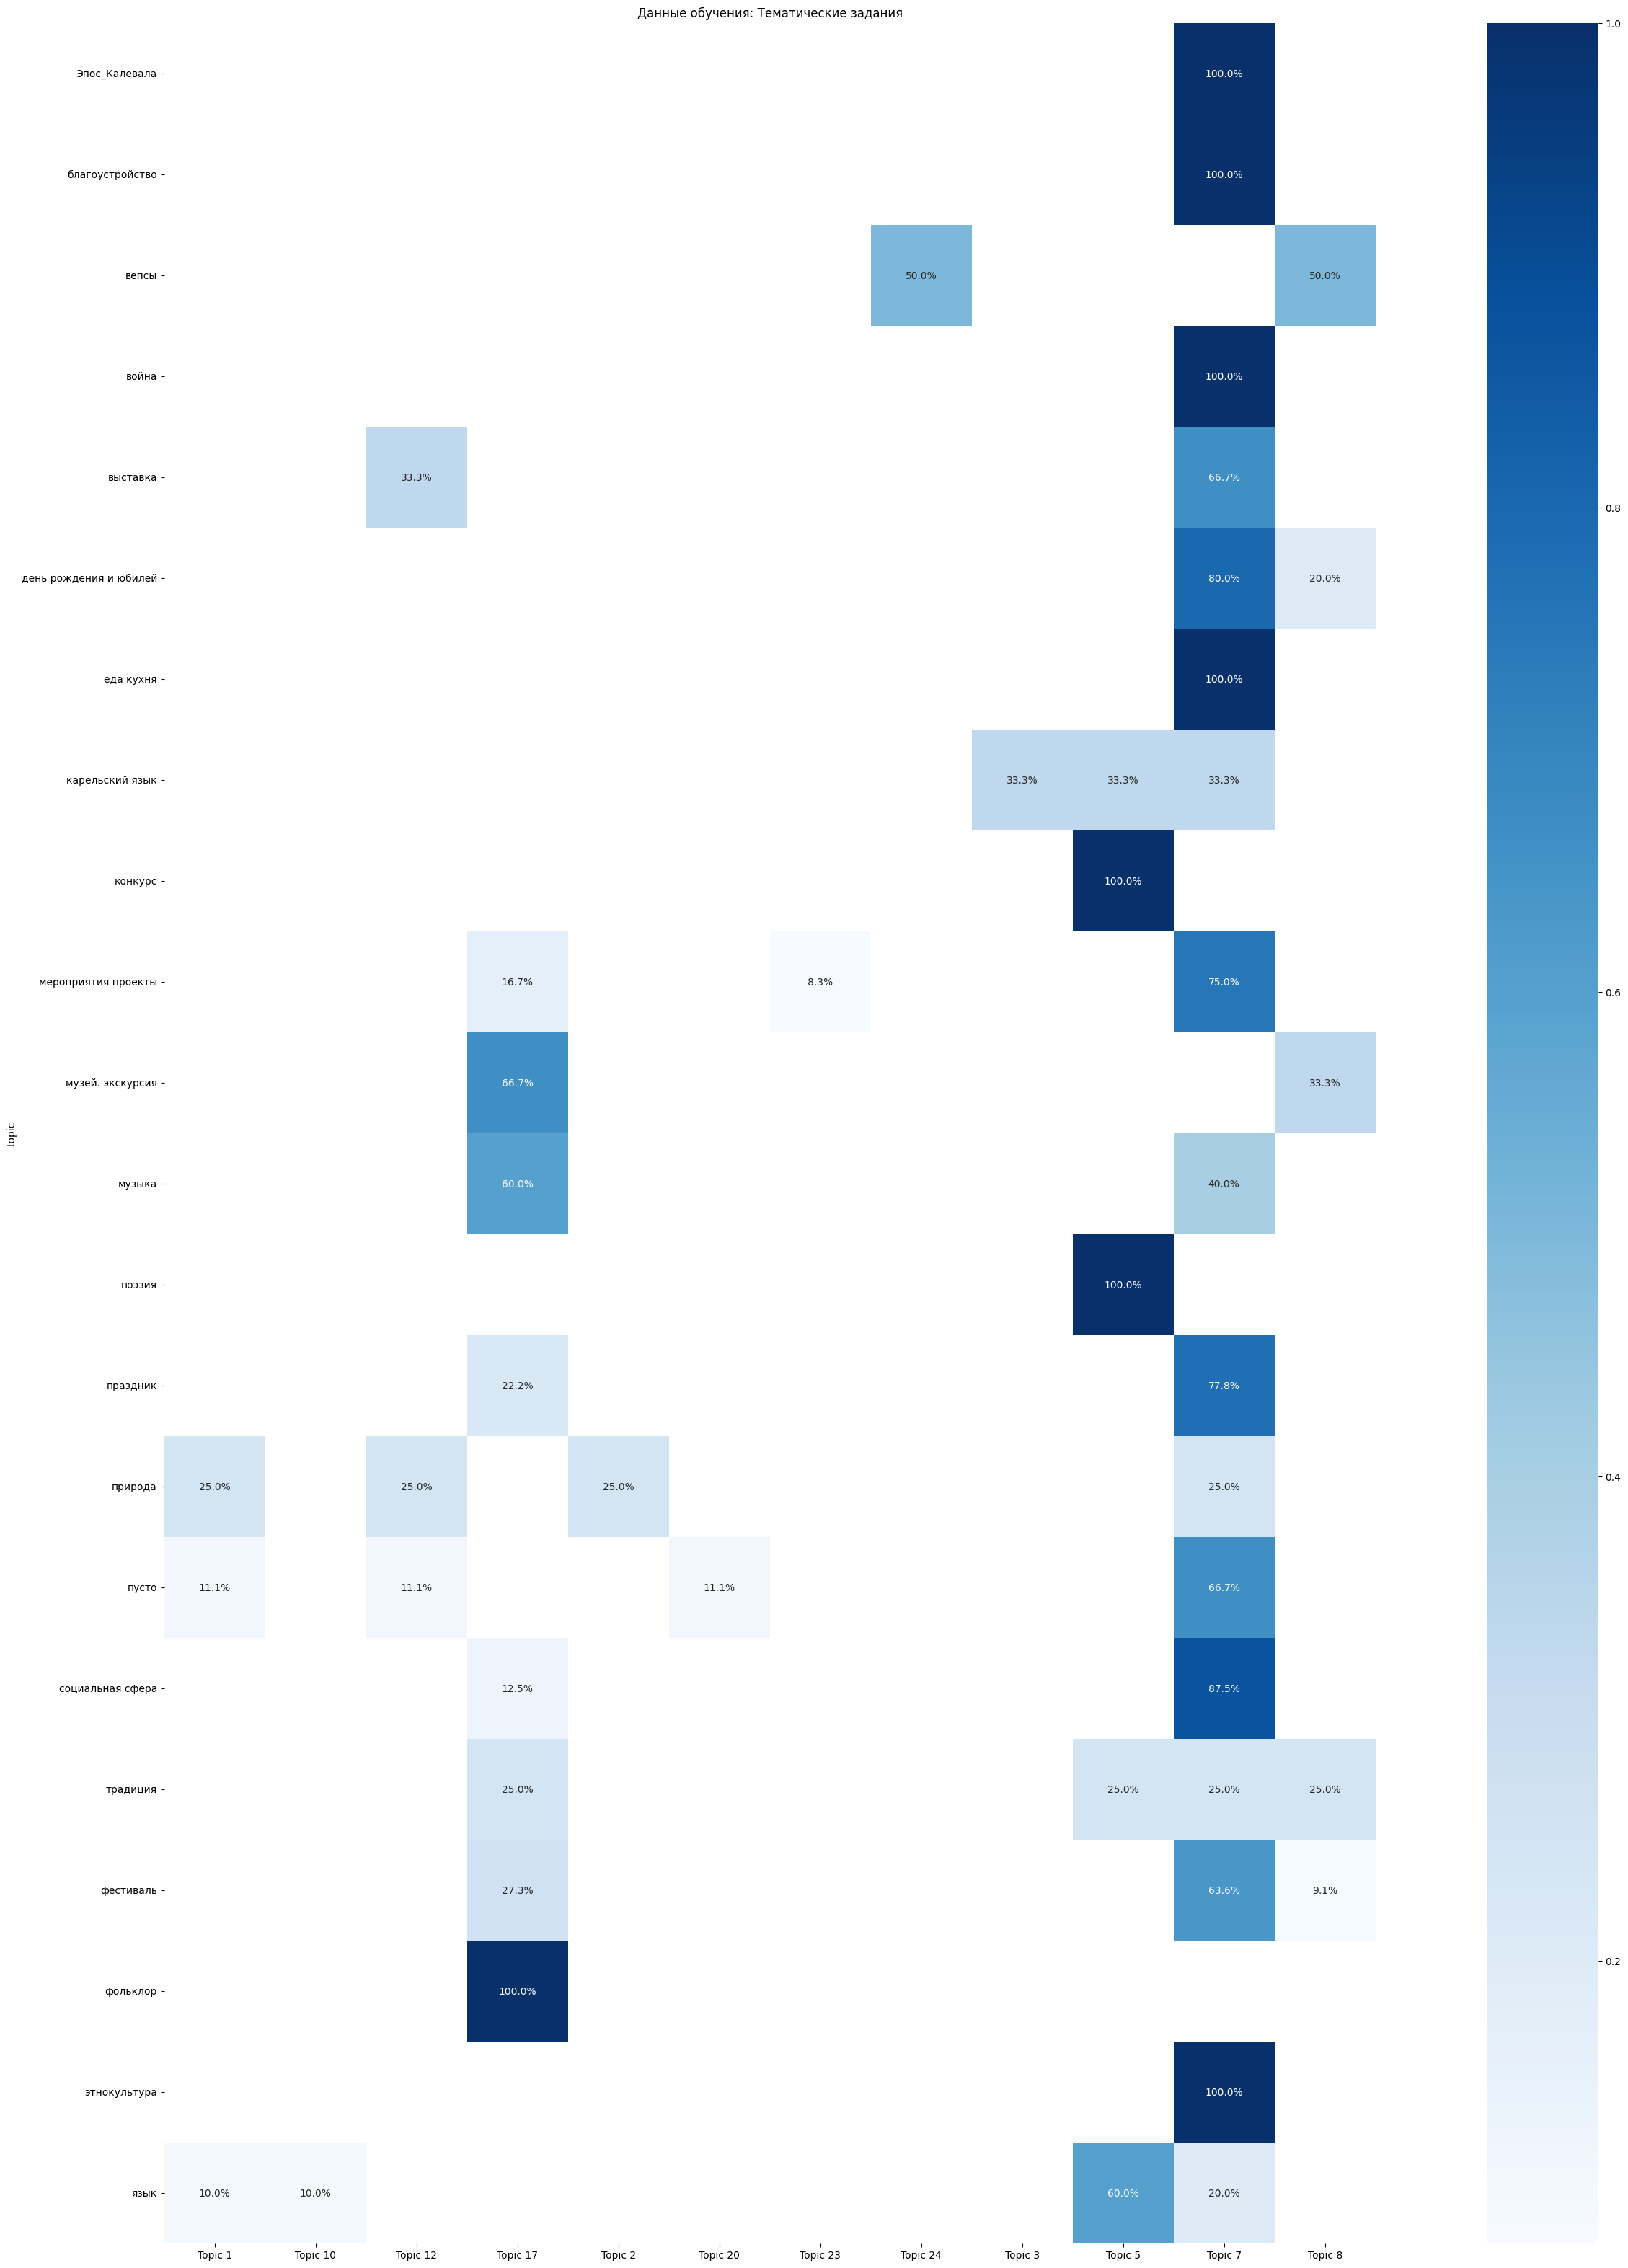

In [67]:
df = test_eval.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True)
plt.figure(figsize=(40, 40))
sns.heatmap(df.groupby(level='topic').value_counts(normalize=True)
            .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Данные обучения: Тематические задания')

In [68]:
test_assignments = test_eval.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True).to_frame('predicted').reset_index()
test_assignments['text'] = test_docs.text.values
test_assignments.head(5)

<ipython-input-68-c37182911221>:1: FutureWarning: DataFrameGroupBy.idxmax with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  test_assignments = test_eval.groupby(level='topic').idxmax(


,topic,predicted,text
0,Эпос_Калевала,Topic 7,Бери друзей - смотри музей! Сегодня приглашае...
1,благоустройство,Topic 7,️🎥Предлагаем вам посмотреть интересный ролик с...
2,благоустройство,Topic 7,💥 Сегодня руководитель Карельской республиканс...
3,благоустройство,Topic 7,"""ОСЕНЬ Въ ГОРОДѣ О.""🍁🍂 МАСТЕР-КЛАСС ПО СКАНДИН..."
4,благоустройство,Topic 7,"Какое растение вепсы называют ""GADAN LUZIK"" бу..."


In [69]:
test_assignments = (test_eval.groupby(level='topic').idxmax(axis=1)
                   .reset_index(-1, drop=True)
                   .to_frame('predicted')
                   .reset_index())

test_assignments['text'] = test_docs.text.values

war_assignments = test_assignments[test_assignments['topic'] == 'война']
war_assignments
war_assignments.to_csv("war.csv")

<ipython-input-69-2aea02cd00df>:1: FutureWarning: DataFrameGroupBy.idxmax with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  test_assignments = (test_eval.groupby(level='topic').idxmax(axis=1)


In [70]:
test_assignments.to_csv("res.csv")